<a href="https://colab.research.google.com/github/Zachary-Wenhao/IML-Team-Attack-Diffusion-Model/blob/data-preparation/Dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install numpy
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:

import numpy as np
import torch
import random
from datasets import load_dataset
from PIL import Image


train = load_dataset("Maysee/tiny-imagenet", split="train")
val = load_dataset("Maysee/tiny-imagenet", split="valid")

print(train)
print(val)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

(…)-00000-of-00001-1359597a978bc4fa.parquet:   0%|          | 0.00/146M [00:00<?, ?B/s]

(…)-00000-of-00001-70d52db3c749a935.parquet:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 100000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})


In [3]:
# fish class has label 0, frog class has label 3

In [4]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset

class ImageNetDataset(Dataset):
    def __init__(self, huggingface_dataset, transform=None):
        """
        Args:
            huggingface_dataset: Our ImageNet dataset from huggingface
            transform: Potential transformation for the images
        """
        self.dataset = huggingface_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        # Apply the transform if specified
        if self.transform:
            image = self.transform(image)

        return image, label


# Example transformation function: this is for use with Vision Transformers
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x), # apparently some images are not RGB
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def tensor_to_pil_image(tensor):
  # Undo normalization
  unnormalize = transforms.Normalize(
      mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
      std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
  )
  tensor = unnormalize(tensor)  # Undo normalization
  tensor = tensor.clip(0, 1)  # Clip values to [0, 1] for valid image range
  tensor = tensor.permute(1, 2, 0)  # Rearrange dimensions to (H, W, C)
  return Image.fromarray((tensor.numpy() * 255).astype('uint8'))  # Convert to PIL

In [5]:
train_dataset = ImageNetDataset(train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataset = ImageNetDataset(val, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

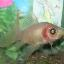

In [6]:
display(train['image'][0])

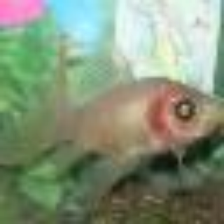

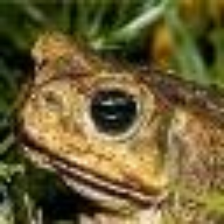

In [7]:
 # Retrieve the transformed image from the dataset
transformed_image, label = train_dataset.__getitem__(0)

# Convert the tensor back to a PIL image
image_to_display = tensor_to_pil_image(transformed_image)

# Display the image using PIL
display(image_to_display)

transformed_image, label = train_dataset.__getitem__(1500)
# Convert the tensor back to a PIL image
image_to_display = tensor_to_pil_image(transformed_image)

# Display the image using PIL
display(image_to_display)

In [8]:
display(train_dataset.__getitem__(0)[0])
print(type(train_dataset.__getitem__(0)[0]))
print(np.array(train_dataset.__getitem__(0)[0]).shape)

tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  0.3652,  0.0569,  0.0569],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.3652,  0.0569,  0.0569],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.3481,  0.0398,  0.0398],
         ...,
         [-0.5596, -0.5596, -0.5596,  ..., -0.8164, -0.8335, -0.8335],
         [-0.5596, -0.5596, -0.5596,  ..., -0.8678, -0.8849, -0.8849],
         [-0.5596, -0.5596, -0.5596,  ..., -0.8678, -0.8849, -0.8849]],

        [[ 0.3452,  0.3452,  0.3452,  ...,  1.1155,  0.8179,  0.8179],
         [ 0.3452,  0.3452,  0.3452,  ...,  1.1155,  0.8179,  0.8179],
         [ 0.3102,  0.3102,  0.3102,  ...,  1.0980,  0.8004,  0.8004],
         ...,
         [ 0.0476,  0.0476,  0.0476,  ..., -0.8978, -0.9153, -0.9153],
         [ 0.0476,  0.0476,  0.0476,  ..., -0.9503, -0.9678, -0.9678],
         [ 0.0476,  0.0476,  0.0476,  ..., -0.9503, -0.9678, -0.9678]],

        [[ 1.5594,  1.5594,  1.5594,  ...,  1.2980,  1.0017,  1.0017],
         [ 1.5594,  1.5594,  1.5594,  ...,  1

<class 'torch.Tensor'>
(3, 224, 224)


In [80]:
def attack(classifier, image, label, adv_image, steps, checkpoint):
  #assumes that classifier correctly classifies image at beginning
  '''classifier is pretrained imagenet classifier, image is clean input,
  adv_image is random image from other class, label is is correct label of image,
  steps is max # of swaps, checkpoint is check output every X steps
  This outputs the corrupted image'''

  #image_array = np.array(image)
  #adv_array = np.array(adv_image)
  image = image.to(device)
  adv_image = adv_image.to(device)
  channel, width, height = image.shape
  #every check_point swaps check if it classifies it correctly

  # Ensure inputs are 4D tensors
  image = image.unsqueeze(0)  # Add batch dimension
  adv_image = adv_image.unsqueeze(0)  # Add batch dimension

  channel, width, height = image.shape[1:]  # Exclude batch dimension
  print(image.shape, image.shape[1:])
  for i in range(steps):
    if i % checkpoint == 0:
      if classifier != None:
        with torch.no_grad():
          # Pass adv_image through the classifier
          prediction = classifier(adv_image)
          predicted_label = prediction.argmax(dim=1).item()
          if predicted_label != label:
              noised_image = adv_image
              print(f'Step {i}, we fooled the classifier: {predicted_label} != {label}')
              return noised_image.squeeze(0)  # Remove batch dimension
      else:
        pass
        #print(f'Step {i}, not yet fooled.')
    random_x = random.randint(0, height - 1)
    random_y = random.randint(0, width - 1)
    image[:, :, random_x, random_y] = (
        adv_image[:, :, random_x, random_y])
    #display(tensor_to_pil_image(image))

  #all steps done, not fooled
  #print(f'After {steps} steps, not fooled.')
  return image.squeeze(0)  # Return image without batch dimension



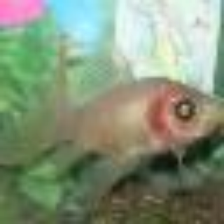

torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
Step 0, not yet fooled.
Step 500, not yet fooled.
Step 1000, not yet fooled.
Step 1500, not yet fooled.
Step 2000, not yet fooled.
Step 2500, not yet fooled.
Step 3000, not yet fooled.
Step 3500, not yet fooled.
Step 4000, not yet fooled.
Step 4500, not yet fooled.
Step 5000, not yet fooled.
Step 5500, not yet fooled.
Step 6000, not yet fooled.
Step 6500, not yet fooled.
Step 7000, not yet fooled.
Step 7500, not yet fooled.
Step 8000, not yet fooled.
Step 8500, not yet fooled.
Step 9000, not yet fooled.
Step 9500, not yet fooled.
After 10000 steps, not fooled.


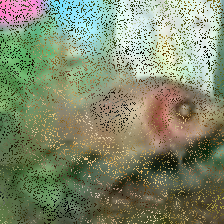

In [51]:
first_fish = train_dataset.__getitem__(0)[0]
display(tensor_to_pil_image(first_fish))
#print(type(first_fish)) torch tensor
#print(np.array(first_fish).shape) (3,224,224)
first_frog = train_dataset.__getitem__(1500)[0]
noised_image = attack(classifier=None, image=first_fish, label=0, adv_image=first_frog, steps=10000, checkpoint=500)
#print(type(noised_image))
#print(type(noised_image_tensor))
#print(noised_image_tensor.shape)
# Pass the tensor to the function
#noised_image = tensor_to_pil_image(noised_image_tensor)
display(tensor_to_pil_image(noised_image))

In [31]:
from torchvision import models

# Load in pre-trained model
model_path = 'fine_tune_classifier.pth'
model = models.efficientnet_b0(weights="IMAGENET1K_V1")  # Use weights instead of pretrained

# Fix classifier to match pretrained model's layer
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, 200)
# Load  fine-tuned weights
state_dict = torch.load('fine_tune_classifier.pth', weights_only=True)

# Load the weights into the model
model.load_state_dict(state_dict)

model.eval()




EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [76]:
#import tqdm
from tqdm.notebook import tqdm  # Use tqdm notebook version for Jupyter

def get_random_image_from_class(dataset, target_class):
    indices = [i for i, (_, label) in enumerate(dataset) if label == target_class]
    random_idx = random.choice(indices)
    return dataset[random_idx][0]  # returns 3x224x224 image


def create_attack_dataset_direct(classifier, dataset, num_classes, attack_fn, **attack_kwargs):
    """
    Creates an attack dataset by applying the attack function directly on the dataset.

    Args:
        classifier: Pretrained model to attack.
        dataset: The dataset to process directly.
        num_classes: The total number of classes in the dataset.
        attack_fn: The attack function to apply to each image.
        attack_kwargs: Additional arguments for the attack function.

    Returns:
        attack_dataset: A list of tuples (corrupted_image, original_label).
    """
    classifier.eval()
    attack_dataset = []

    for idx in tqdm(range(len(dataset)), dynamic_ncols=True, leave=False, position=0):  # Iterate directly through the dataset indices
        image, label = dataset[idx]  # Access image and label directly

        # Determine the next class (class+1) with wrapping
        next_class = (label + 1) % num_classes

        # Get a random adversarial image from the next class
        adv_image = get_random_image_from_class(dataset, next_class)

        # Perform attack using the provided attack function
        corrupted_image = attack_fn(
            classifier=classifier,
            image=image,
            label=label,
            adv_image=adv_image,
            **attack_kwargs
        )

        # Append the corrupted image and its label to the attack dataset
        attack_dataset.append((corrupted_image, label))

    return attack_dataset


In [81]:
device = next(model.parameters()).device

train_attack_dataset = create_attack_dataset_direct(
    classifier=model,
    dataset=train_dataset,
    num_classes=200,
    attack_fn=attack,
    steps=5000,
    checkpoint=1000
)

  0%|          | 0/100000 [00:00<?, ?it/s]

torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224])
Step 0, we fooled the classifier: 1 != 0


KeyboardInterrupt: 

cuda:0
